### Pacotes:

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm

from bcb import sgs
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

In [90]:
from mapie.metrics.regression import (
    regression_coverage_score,
    regression_mean_width_score, coverage_width_based,
)
from mapie.regression import TimeSeriesRegressor
from mapie.subsample import BlockBootstrap

warnings.simplefilter("ignore")

In [91]:
from tsbootstrap import MovingBlockBootstrap
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.enbpi import EnbPIForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.detrend import Deseasonalizer
from sklearn.base import clone
from sklearn.utils import check_random_state
from sktime.utils.parallel import parallelize
from sktime.forecasting.compose import DirectTabularRegressionForecaster

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_longley
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.compose import SkforecastAutoreg
# from sktime.performance_metrics.forecasting import (
#     mean_absolute_error,              # MAE
#     mean_squared_error,               # MSE / RMSE
#     mean_absolute_percentage_error,   # MAPE / sMAPE
#     mean_absolute_scaled_error        # MASE
# )
from sklearn.metrics import r2_score    # R² (coeficiente de determinação)
from sktime.forecasting.var import VAR

from deel.puncc.regression import EnbPI
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.regression import AdaptiveEnbPI
from deel.puncc.api.prediction import MeanVarPredictor
from deel.puncc.metrics import regression_mean_coverage
from deel.puncc.metrics import regression_sharpness

### Leitura dos Dados:

In [13]:
df_selic = sgs.get({'selic': 432}, start='2016-01-01', end='2025-02-05')

df_selic

,selic
Date,
2016-01-01,14.25
2016-01-02,14.25
2016-01-03,14.25
2016-01-04,14.25
2016-01-05,14.25
...,...
2025-02-01,13.25
2025-02-02,13.25
2025-02-03,13.25


In [14]:
# df_selic = pd.read_excel(r'C:\Users\jonas\OneDrive - MSFT\Desktop\Mestrado USP - EST\Dissertação\Códigos\Dados\selic a.a diario.xlsx')
# df_selic = df_selic.set_index(df_selic.columns[0])

# # df_selic.plot(title='Variação diária da taxa Selic')
# df_selic

Coletando outros índices:

In [15]:
CODES_DICT = {
    'ipca': 433,
    'igpm': 189
}

df = sgs.get(CODES_DICT, start='2016-01-01', end='2025-02-05')
df

,ipca,igpm
Date,,
2016-01-01,1.27,1.14
2016-02-01,0.90,1.29
2016-03-01,0.43,0.51
2016-04-01,0.61,0.33
2016-05-01,0.78,0.82
...,...,...
2024-10-01,0.56,1.52
2024-11-01,0.39,1.30
2024-12-01,0.52,0.94


In [16]:
df['selic'] = df_selic['selic']
df = df.ffill()

df

,ipca,igpm,selic
Date,,,
2016-01-01,1.27,1.14,14.25
2016-02-01,0.90,1.29,14.25
2016-03-01,0.43,0.51,14.25
2016-04-01,0.61,0.33,14.25
2016-05-01,0.78,0.82,14.25
...,...,...,...
2024-10-01,0.56,1.52,10.75
2024-11-01,0.39,1.30,10.75
2024-12-01,0.52,0.94,11.25


Criando a Target:

In [17]:
df.loc[:, 'y'] = df['selic'].shift(-1)
df = df.dropna()
df

,ipca,igpm,selic,y
Date,,,,
2016-01-01,1.27,1.14,14.25,14.25
2016-02-01,0.90,1.29,14.25,14.25
2016-03-01,0.43,0.51,14.25,14.25
2016-04-01,0.61,0.33,14.25,14.25
2016-05-01,0.78,0.82,14.25,14.25
...,...,...,...,...
2024-09-01,0.44,0.62,10.50,10.75
2024-10-01,0.56,1.52,10.75,10.75
2024-11-01,0.39,1.30,10.75,11.25


### Modelos:

#### Machine Learning:

##### Separação Treino e Teste:

In [18]:
X = df.drop(['y'], axis=1)
y = df['y']

test_size = 0.3  # <-- 30% dos dados serão usados para teste.
n_splits = int(1 / test_size)

tscv = TimeSeriesSplit(n_splits=n_splits).split(X,y)

for train_index, test_index in tscv:
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]

X_train = train_data.drop(columns=['y'], axis=1)
X_test = test_data.drop(columns=['y'], axis=1)

y_train = train_data['y']
y_test = test_data['y']

print('Tamanho do treino:' + str(len(X_train)))
print('Tamanho do teste:' + str(len(X_test)))

Tamanho do treino:82
Tamanho do teste:27


In [19]:
# for lag in range(1, 8):
#     df[f'lag_{lag}'] = df['y'].shift(lag)
# df.dropna(inplace=True)

In [20]:
# X, y = df.drop(['y'], axis=1), df['y']

# y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.3)

# print('Tamanho do treino:' + str(len(X_train)))
# print('Tamanho do teste:' + str(len(X_test)))

##### Features Engenharia:

In [21]:
def regression_angle(series):
    # Eixo x
    x = np.arange(len(series))

    # Ajusta a linha da regressão
    slope, intercept, r_value, p_value, std_err = linregress(x, series)

    # Ângulo em graus
    angle_rad = np.arctan(slope)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

regression_angle([1, 2, 3, 4, 5])

45.0

In [22]:
def feature_engineering(df):
    df_features = pd.DataFrame()
    df.index = df.index

    # Valor atual da Selic
    # df_features['selic'] = df['selic']

    # Média dos últimos 6 meses para Selic
    df_features['selic_mean_6m'] = df['selic'].rolling(6).mean().fillna(0)

    # Tendência dos indicadores macro
    df_features['igpm_trend'] = df['igpm'].rolling(10).apply(lambda x: regression_angle(x)).fillna(0)
    df_features['selic_trend'] = df['selic'].rolling(10).apply(lambda x: regression_angle(x)).fillna(0)
    df_features['ipca_trend'] = df['ipca'].rolling(10).apply(lambda x: regression_angle(x)).fillna(0)

    return df_features


# Cria as features (X) para treino e teste
x_train_ok = feature_engineering(X_train)
x_test_ok = feature_engineering(X_test)

X_train = pd.concat([x_train_ok, X_train], axis=1)

X_test = pd.concat([x_test_ok, X_test], axis=1)

X_train.tail(5)

,selic_mean_6m,igpm_trend,selic_trend,ipca_trend,ipca,igpm,selic
Date,,,,,,,
2022-06-01,10.916667,6.842773,39.289407,-2.144985,0.67,0.59,12.75
2022-07-01,11.583333,-1.024270,37.585370,-6.383636,-0.68,0.21,13.25
2022-08-01,12.250000,-7.427400,34.640948,-8.000260,-0.36,-0.70,13.25
2022-09-01,12.750000,-15.725933,33.206570,-9.418395,-0.29,-0.95,13.75
2022-10-01,13.083333,-20.075061,28.610460,-8.129616,0.59,-0.97,13.75


In [33]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=3,
    random_state=1,
    n_jobs=-1,
    bootstrap=True,    # fundamental para amostragem com reposição
    oob_score=True,    # habilita cálculo de OOB
)

# Treina o modelo
model.fit(X_train, y_train)

# Realiza as previsões
preds = model.predict(X_test)
preds

array([13.77702931, 13.77702931, 13.77702931, 13.77702931, 13.77702931,
       13.77702931, 13.77702931, 13.77702931, 13.77702931, 13.73636884,
       13.60754024, 12.64990089, 12.61967943, 12.01109769, 11.78361041,
       11.00192175, 10.90684106, 10.62277832, 10.62277832, 10.19108516,
       10.33410416, 10.19661442, 10.3006771 , 10.98558587, 11.00643376,
       11.30421045, 12.14926561])

In [35]:
def ajust_step_selic(pred):
    return round(pred / 0.25) * 0.25

preds = [ajust_step_selic(pred) for pred in preds]
print(preds)

[13.75, 13.75, 13.75, 13.75, 13.75, 13.75, 13.75, 13.75, 13.75, 13.75, 13.5, 12.75, 12.5, 12.0, 11.75, 11.0, 11.0, 10.5, 10.5, 10.25, 10.25, 10.25, 10.25, 11.0, 11.0, 11.25, 12.25]


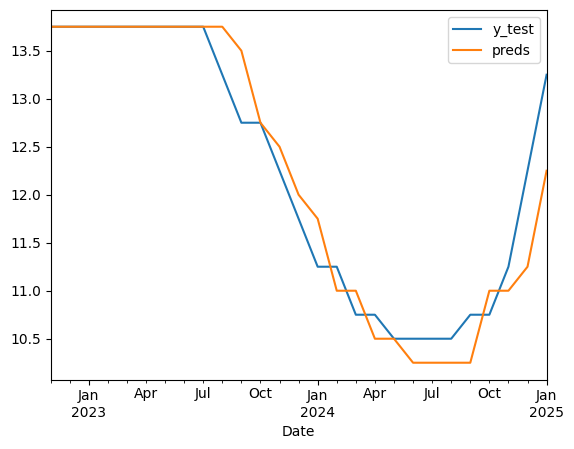

In [36]:
df_preds = pd.DataFrame()
df_preds['y_test'] = y_test
df_preds['preds'] = preds

df_preds.plot();

In [37]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Avaliação do modelo no conjunto de treino:
train_mae    = mean_absolute_error(y_train, y_train_pred)
train_rmse   = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Avaliação do modelo no conjunto de teste:
test_mae    = mean_absolute_error(y_test, y_test_pred)
test_rmse   = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Verifica o status do modelo:
if train_mae < test_mae - 0.1:
        status = "\033[31mOverfitting\033[0m"
elif train_mae > test_mae + 0.1:
        status = "\033[31mUnderfitting\033[0m"
else:
        status = "\033[32mBom!\033[0m"

print(' ')
print(f"Model: \033[34mFloresta Aleatória\033[0m")
print(' ')
print(f"Training MAE: {train_mae:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(' ')
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(' ')
print(f"Status: {status}")

 
Model: Floresta Aleatória
 
Training MAE: 0.2933
Training RMSE: 0.4094
 
Test MAE: 0.2689
Test RMSE: 0.3960
 
Status: Bom!


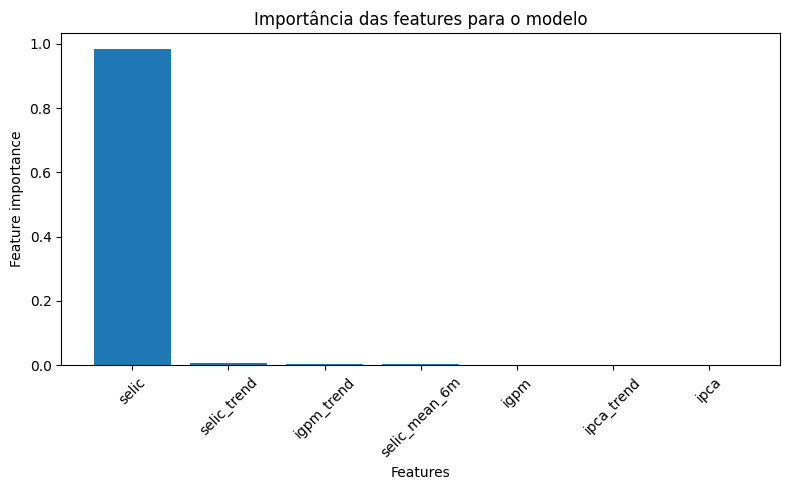

In [38]:
# Nomes das features
features = X_train.columns

# Importância das features
importances = model.feature_importances_

# Ordena as features por importância
indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in indices]

# Exibe o gráfico
plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), sorted_features, rotation=45)
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.title('Importância das features para o modelo')
plt.tight_layout()
plt.show()

### Regiões de Previsão:

#### Regiões com EnBPi:

In [113]:
# Wrap model in a predictor:
rf_predictor = BasePredictor(model, is_trained=True)

# CP method initialization:
enbpi = EnbPI(
    rf_predictor,
    B = 360,  # Número de réplicas bootstrap. 
    # agg_func_loo = lambda preds: preds.mean(axis=0),
    agg_func_loo = lambda preds, axis=0, *args: np.quantile(preds, 0.10, *args, axis=axis),
    random_state = 42
)

enbpi.fit(X_train.values, y_train)

In [114]:
y_pred, y_pred_lower, y_pred_upper = enbpi.predict(
    X_test, alpha=.10, y_true=y_test, s=None
)

y_pred, y_pred_lower, y_pred_upper = (
    [ajust_step_selic(pred) for pred in arr]
    for arr in (y_pred, y_pred_lower, y_pred_upper)
)

coverage = regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = regression_sharpness(
    y_pred_lower=np.array(y_pred_lower),
    y_pred_upper=np.array(y_pred_upper)
)

print(f"Cobertura empírica: {coverage*100:.2f}%, Largura média: {width:.3f}")

Cobertura empírica: 100.00%, Largura média: 2.241


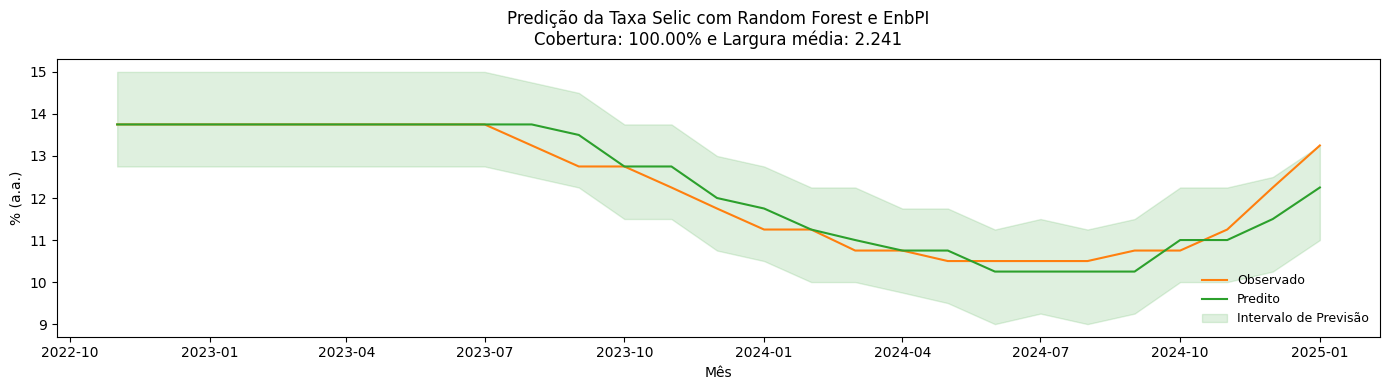

In [ ]:

plt.figure(figsize=(14, 4))
plt.plot(
    y_test.index, y_test.values,
    color="tab:orange", linewidth=1.5,
    label="Observado"
)
plt.plot(
    y_test.index, y_pred,
    color="tab:green", linewidth=1.5,
    label="Predito"
)
plt.fill_between(
    y_test.index,
    y_pred_lower,
    y_pred_upper,
    color="tab:green", alpha=0.15,
    label="Intervalo de Previsão"
)
plt.title(
    f"Predição da Taxa Selic com Random Forest e EnbPI\n"
    f"Cobertura: {coverage*100:.2f}% e Largura média: {width:.3f}",
    fontsize=12, pad=10)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel("Mês", fontsize=10)
plt.ylabel("% (a.a.)", fontsize=10)
plt.legend(frameon=False, fontsize=9, loc='lower right')
plt.tight_layout()
plt.show()

In [22]:
# Cria DataFrame para previsões ajustadas
df_preds = pd.DataFrame({
    'y_test': y_test,
    'y_pred_lower': y_pred_lower,
    'y_pred': y_pred,
    'y_pred_upper': y_pred_upper
})

df_preds.head()

,y_test,y_pred_lower,y_pred,y_pred_upper
Date,,,,
2022-11-01,13.75,12.25,13.75,15.25
2022-12-01,13.75,12.25,13.75,15.25
2023-01-01,13.75,12.25,13.75,15.25
2023-02-01,13.75,12.25,13.75,15.25
2023-03-01,13.75,12.25,13.75,15.25


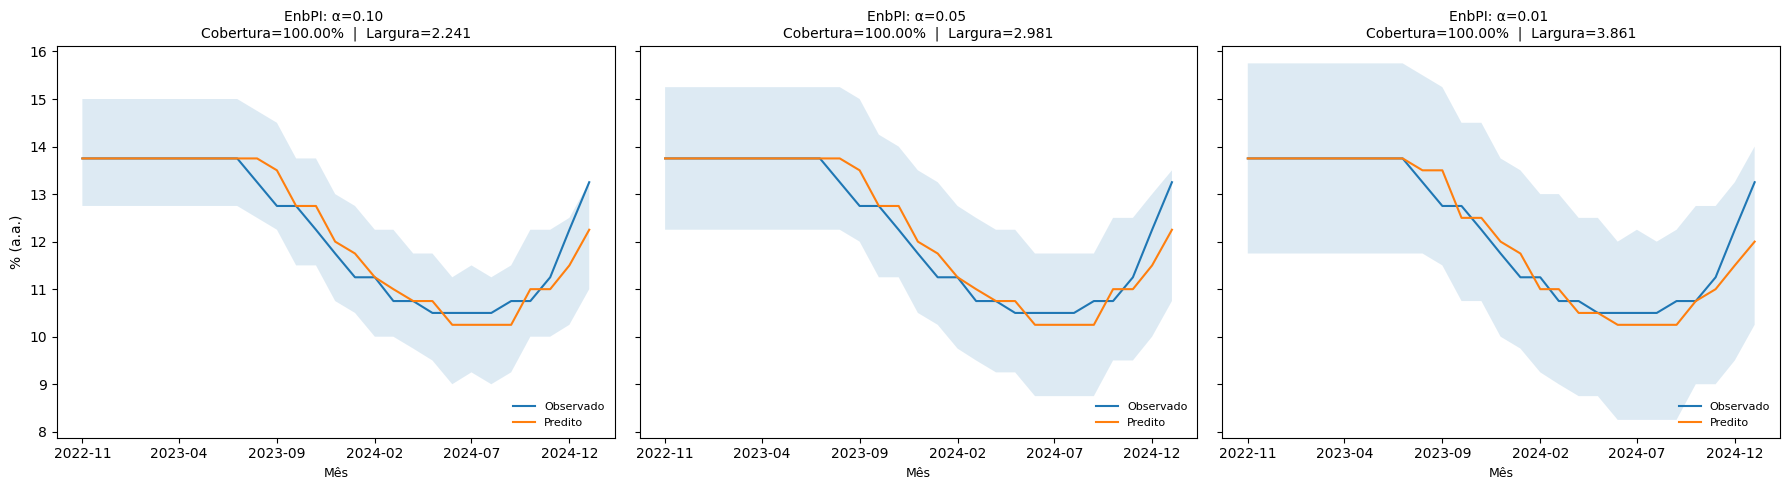

In [125]:
# 1) Envolvendo o RandomForest já treinado em um BasePredictor
rf_predictor = BasePredictor(model, is_trained=True)

# 2) Níveis de alpha a comparar
alphas = [0.10, 0.05, 0.01]

# 3) Configura figura com 1x3 subplots e eixo y compartilhado
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, alpha in zip(axes, alphas):
    # Inicialização do EnbPI para o alpha atual
    enbpi = EnbPI(
        predictor     = rf_predictor,
        B             = 360,
        agg_func_loo  = lambda preds, axis=0, *args: np.quantile(preds, alpha, axis=axis, *args),
        random_state  = 42
    )
    enbpi.fit(X_train.values, y_train.values)

    # Previsão e intervalos
    y_pred, y_lower, y_upper = enbpi.predict(
        X_test.values, alpha=alpha, y_true=y_test.values, s=None
    )
    # Ajuste do passo Selic
    y_pred  = [ajust_step_selic(p) for p in y_pred]
    y_lower = [ajust_step_selic(p) for p in y_lower]
    y_upper = [ajust_step_selic(p) for p in y_upper]

    # Cálculo de cobertura e largura
    coverage = regression_mean_coverage(y_test, y_lower, y_upper)
    width    = regression_sharpness(
        y_pred_lower = np.array(y_lower),
        y_pred_upper = np.array(y_upper)
    )

    # Plot
    ax.plot(y_test.index, y_test.values, label="Observado", linewidth=1.5)
    ax.plot(y_test.index, y_pred,       label="Predito",  linewidth=1.5)
    ax.fill_between(y_test.index, y_lower, y_upper, alpha=0.15)

    # — Aqui: reduz a frequência dos ticks de data —
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))  # um tick a cada 3 meses
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=0)

    ax.set_title(
        f"EnbPI: α={alpha:.2f} \nCobertura={coverage*100:.2f}%  |  Largura={width:.3f}",
        fontsize=10, pad=6
    )
    ax.set_xlabel("Mês", fontsize=9)

# Rótulo do eixo y e legendas
axes[0].set_ylabel("% (a.a.)", fontsize=10)
for ax in axes:
    ax.legend(frameon=False, fontsize=8, loc='lower right')

plt.tight_layout()
plt.show()

#### Clássica:

In [ ]:
oob_pred = model.oob_prediction_          # predições OOB para cada ponto de treino
residuals = y_train - oob_pred
sigma_hat = residuals.std(ddof=1)         # desvio-padrão amostral

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
alpha = 0.01
z = norm.ppf(1 - alpha/2)

In [ ]:
lower_simple = y_pred - z * sigma_hat
upper_simple = y_pred + z * sigma_hat

In [ ]:
all_tree_preds = np.stack(
    [t.predict(X_test) for t in model.estimators_],
    axis=1
)
var_rf = all_tree_preds.var(axis=1, ddof=1)
sigma_tot = np.sqrt(sigma_hat**2 + var_rf)

lower_adjusted = y_pred - z * sigma_tot
upper_adjusted = y_pred + z * sigma_tot

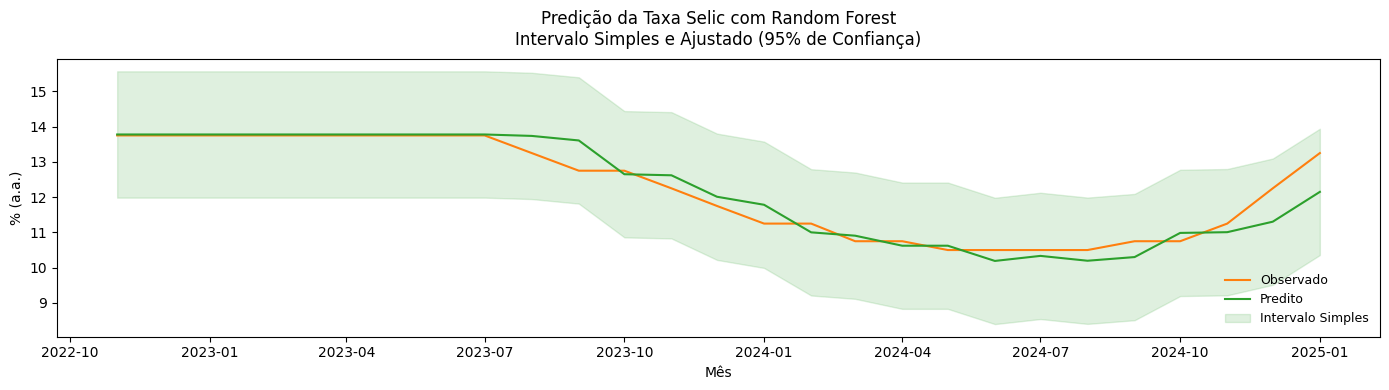

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(
    y_test.index, y_test.values,
    color="tab:orange", linewidth=1.5,
    label="Observado"
)
plt.plot(
    y_test.index, y_pred,
    color="tab:green", linewidth=1.5,
    label="Predito"
)
plt.fill_between(
    y_test.index,
    lower_simple,
    upper_simple,
    color="tab:green", alpha=0.15,
    label="Intervalo Simples"
)
plt.title(
    f"Predição da Taxa Selic com Random Forest\n"
    f"Intervalo Simples e Ajustado (95% de Confiança)",
    fontsize=12, pad=10
)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel("Mês", fontsize=10)
plt.ylabel("% (a.a.)", fontsize=10)
plt.legend(frameon=False, fontsize=9, loc='lower right')
plt.tight_layout()
plt.show()

In [80]:
widths = upper_simple - lower_simple        # vetor de w_i

# 2) Largura média
mean_width = np.mean(widths)
print(f"Largura média do intervalo: {mean_width:.4f}")

Largura média do intervalo: 3.5815


In [81]:
inside = (y_test >= lower_simple) & (y_test <= upper_simple)  # vetor booleano I_i
coverage = np.mean(inside)                      # proporção de True

print(f"Cobertura empírica: {coverage*100:.2f}%")

Cobertura empírica: 100.00%


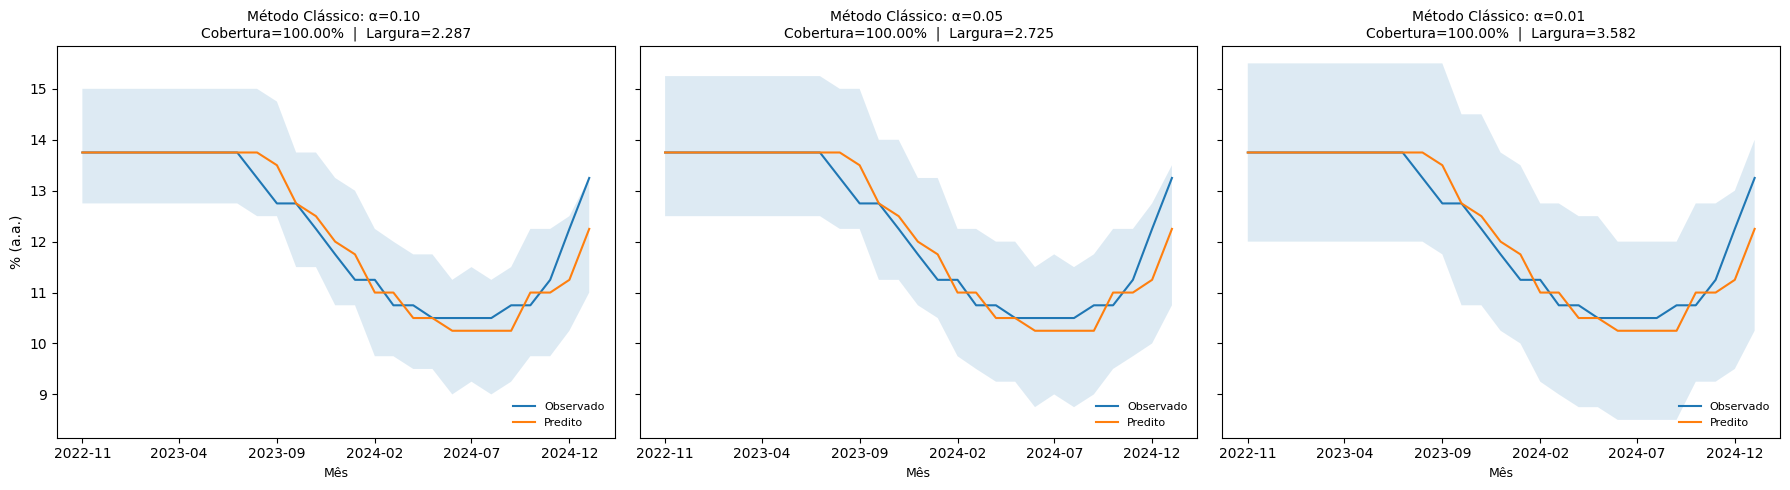

In [124]:
# 1) Cálculo único de σ̂ a partir das predições OOB
oob_pred   = model.oob_prediction_           # OOB para cada ponto de treino
residuals  = y_train - oob_pred
sigma_hat  = residuals.std(ddof=1)           # desvio-padrão amostral

# 2) Predição pontual para o teste (idéntica em todos os subplots)
y_pred_base = model.predict(X_test)

# 3) Níveis de alpha a comparar
alphas = [0.10, 0.05, 0.01]

# 4) Configura 1×3 subplots com eixo y compartilhado
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, alpha in zip(axes, alphas):
    # 5) Quantil z correspondente
    z = norm.ppf(1 - alpha/2)
    
    # 6) Intervalo simples
    lower = y_pred_base - z * sigma_hat
    upper = y_pred_base + z * sigma_hat
    
    # 7) Ajuste do “passo Selic”
    y_pred   = [ajust_step_selic(p) for p in y_pred_base]
    lower_ss = [ajust_step_selic(p) for p in lower]
    upper_ss = [ajust_step_selic(p) for p in upper]
    
    # 8) Métricas de cobertura e largura
    coverage = np.mean((y_test.values >= lower) & (y_test.values <= upper))
    width    = np.mean(upper - lower)
    
    # 9) Plot
    ax.plot(y_test.index, y_test.values, label="Observado", linewidth=1.5)
    ax.plot(y_test.index, y_pred,        label="Predito",  linewidth=1.5)
    ax.fill_between(y_test.index, lower_ss, upper_ss, alpha=0.15)
    
    # 10) Redução de ticks no eixo X: um tick a cada 3 meses
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=0)
    
    ax.set_title(
        f"Método Clássico: α={alpha:.2f} \nCobertura={coverage*100:.2f}%  |  Largura={width:.3f}",
        fontsize=10, pad=6
    )
    ax.set_xlabel("Mês", fontsize=9)

# 11) Rótulo do eixo Y e legendas
axes[0].set_ylabel("% (a.a.)", fontsize=10)
for ax in axes:
    ax.legend(frameon=False, fontsize=8, loc='lower right')

plt.tight_layout()
plt.show()

#### Plotes legais:

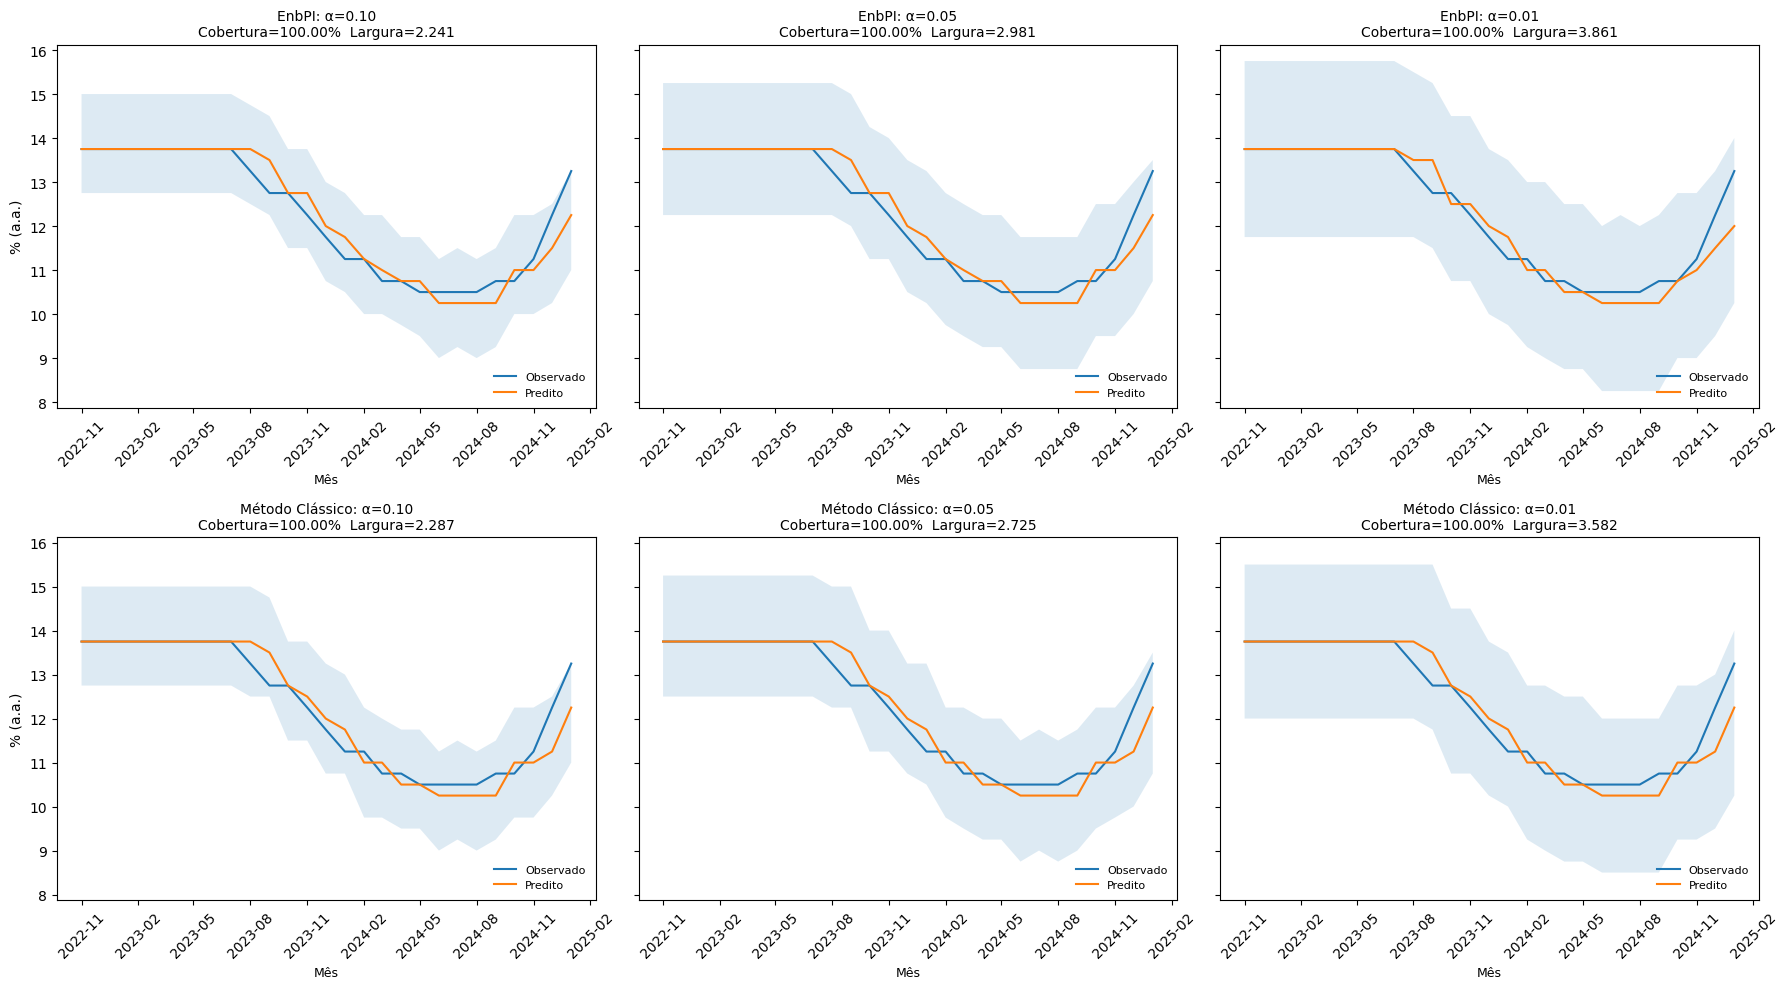

In [ ]:
# Pré-configurações comuns
# Encapsula o RF já treinado
rf_predictor = BasePredictor(model, is_trained=True)

# Cálculo do σ̂ via OOB
oob_pred  = model.oob_prediction_
residuals = y_train.values - oob_pred
sigma_hat = residuals.std(ddof=1)

# Predição pontual de base para simples intervalos
y_pred_base = model.predict(X_test.values)

# Níveis de confiança
alphas = [0.10, 0.05, 0.01]

#Cria grid 2×3, sharey para comparação direta
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

#EnbPI para cada α 
for j, alpha in enumerate(alphas):
    ax = axes[0, j]
    # Instancia e ajusta o método EnbPI
    enbpi = EnbPI(
        predictor    = rf_predictor,
        B            = 360,
        agg_func_loo = lambda preds, axis=0, *args: np.quantile(preds, alpha, axis=axis, *args),
        random_state = 42
    )
    enbpi.fit(X_train.values, y_train.values)

    # Previsão com intervalos conformes
    y_pred, y_lower, y_upper = enbpi.predict(
        X_test.values,
        alpha  = alpha,
        y_true = y_test.values,
        s      = None
    )
    # Ajuste “passo Selic”
    y_pred  = [ajust_step_selic(p) for p in y_pred]
    y_lower = [ajust_step_selic(p) for p in y_lower]
    y_upper = [ajust_step_selic(p) for p in y_upper]

    # Métricas
    coverage = regression_mean_coverage(y_test, y_lower, y_upper)
    width    = regression_sharpness(
        y_pred_lower = np.array(y_lower),
        y_pred_upper = np.array(y_upper)
    )

    # Plot
    ax.plot(y_test.index, y_test.values, label="Observado", linewidth=1.5)
    ax.plot(y_test.index, y_pred,       label="Predito",  linewidth=1.5)
    ax.fill_between(y_test.index, y_lower, y_upper, alpha=0.15)

    # Formatação do eixo X
    locator = mdates.MonthLocator(interval=3)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

    ax.set_title(
        f"EnbPI: α={alpha:.2f}\nCobertura={coverage*100:.2f}%  Largura={width:.3f}",
        fontsize=10, pad=6
    )
    if j == 0:
        ax.set_ylabel("% (a.a.)", fontsize=10)
    ax.set_xlabel("Mês", fontsize=9)
    ax.legend(frameon=False, fontsize=8, loc='lower right')

# Intervalo Simples para cada α
for j, alpha in enumerate(alphas):
    ax = axes[1, j]
    # quantil z
    z = norm.ppf(1 - alpha/2)
    # limites simples
    lower = y_pred_base - z * sigma_hat
    upper = y_pred_base + z * sigma_hat

    # Ajuste “passo Selic”
    y_pred   = [ajust_step_selic(p) for p in y_pred_base]
    lower_ss = [ajust_step_selic(p) for p in lower]
    upper_ss = [ajust_step_selic(p) for p in upper]

    # Métricas empíricas
    coverage = np.mean((y_test.values >= lower) & (y_test.values <= upper))
    width    = np.mean(upper - lower)

    # Plot
    ax.plot(y_test.index, y_test.values, label="Observado", linewidth=1.5)
    ax.plot(y_test.index, y_pred,        label="Predito",  linewidth=1.5)
    ax.fill_between(y_test.index, lower_ss, upper_ss, alpha=0.15)

    # Formatação do eixo X
    locator = mdates.MonthLocator(interval=3)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

    ax.set_title(
        f"Método Clássico: α={alpha:.2f}\nCobertura={coverage*100:.2f}%  Largura={width:.3f}",
        fontsize=10, pad=6
    )
    if j == 0:
        ax.set_ylabel("% (a.a.)", fontsize=10)
    ax.set_xlabel("Mês", fontsize=9)
    ax.legend(frameon=False, fontsize=8, loc='lower right')

plt.tight_layout()
plt.show()
